In [2]:
!pip install folium

In [3]:
!pip install contextily

In [35]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [40]:
df = pd.read_csv("/content/drive/MyDrive/Praktikum_ML/Praktikum 11/data/kabupaten_kota.csv")
df.head()


,id,name,province_id,latitude,longitude,source
0,11.01,Aceh Selatan,11,3.067979,97.468771,OSM
1,11.02,Aceh Tenggara,11,3.338797,97.745642,OSM
2,11.03,Aceh Timur,11,4.701663,97.645039,OSM
3,11.04,Aceh Tengah,11,4.564267,96.961893,OSM
4,11.05,Aceh Barat,11,4.442252,96.192983,OSM


In [42]:
print("Jumlah Baris Awal:", len(df))
df_clean = df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
print("Jumlah Baris setelah dropna:", len(df_clean))

Jumlah Baris Awal: 514
Jumlah Baris setelah dropna: 511


In [43]:
X = df_clean[['latitude', 'longitude']]

In [44]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("Data berhasil dinormalisasi.")

Data berhasil dinormalisasi.


Parameter Epsilon

In [45]:
k = 2 * X.shape[1] # k = 4 (rule of thumb)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

In [46]:
distances = np.sort(distances[:, 1], axis=0)

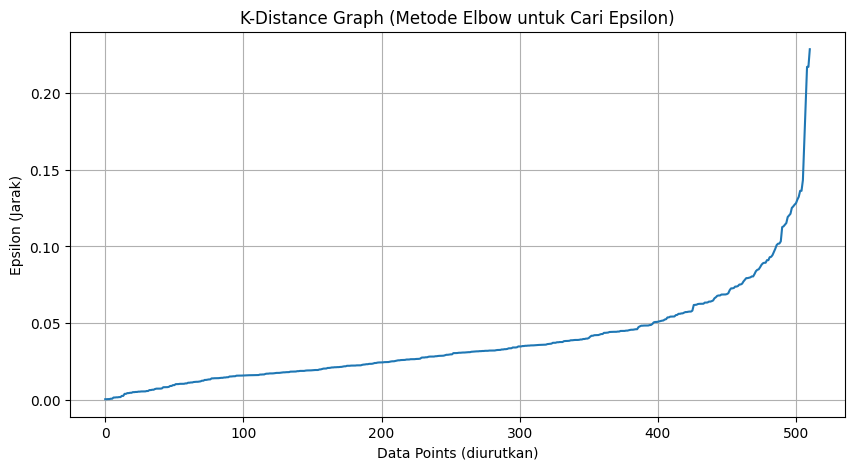

Perhatikan grafik di atas. Titik di mana garis melengkung tajam adalah epsilon optimal.


In [47]:
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph (Metode Elbow untuk Cari Epsilon)')
plt.xlabel('Data Points (diurutkan)')
plt.ylabel('Epsilon (Jarak)')
plt.grid(True)
plt.show()

print("Perhatikan grafik di atas. Titik di mana garis melengkung tajam adalah epsilon optimal.")

Pemodelan dengan DBSCAN

In [48]:
epsilon = 0.15
min_samples = 5

print(f"Menjalankan DBSCAN dengan eps={epsilon} dan min_samples={min_samples}")

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

Menjalankan DBSCAN dengan eps=0.15 dan min_samples=5


In [49]:
df_clean['Cluster'] = clusters

In [50]:
df_clean['Label'] = df_clean['Cluster'].apply(
    lambda x: 'Noise (Terpencil)' if x == -1 else f'Cluster {x}'
)

In [51]:
print("\nDistribusi Cluster:")
print(df_clean['Label'].value_counts().head(10))


Distribusi Cluster:
Label
Cluster 0            308
Cluster 3             58
Cluster 1             51
Cluster 5             36
Cluster 2             26
Noise (Terpencil)     25
Cluster 4              7
Name: count, dtype: int64


Evaluasi Silhouette Score

In [52]:
if len(set(clusters)) > 1:
    score = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {score:.4f}")
    if score > 0.5:
        print("(Cluster terpisah dengan sangat baik)")
    elif score > 0.2:
        print("(Cluster cukup baik)")
    else:
        print("(Cluster tumpang tindih atau kurang padat)")
else:
    print("Silhouette Score tidak dapat dihitung (Hanya terbentuk 1 cluster/semua noise).")


Silhouette Score: 0.1313
(Cluster tumpang tindih atau kurang padat)


VISUALISASI

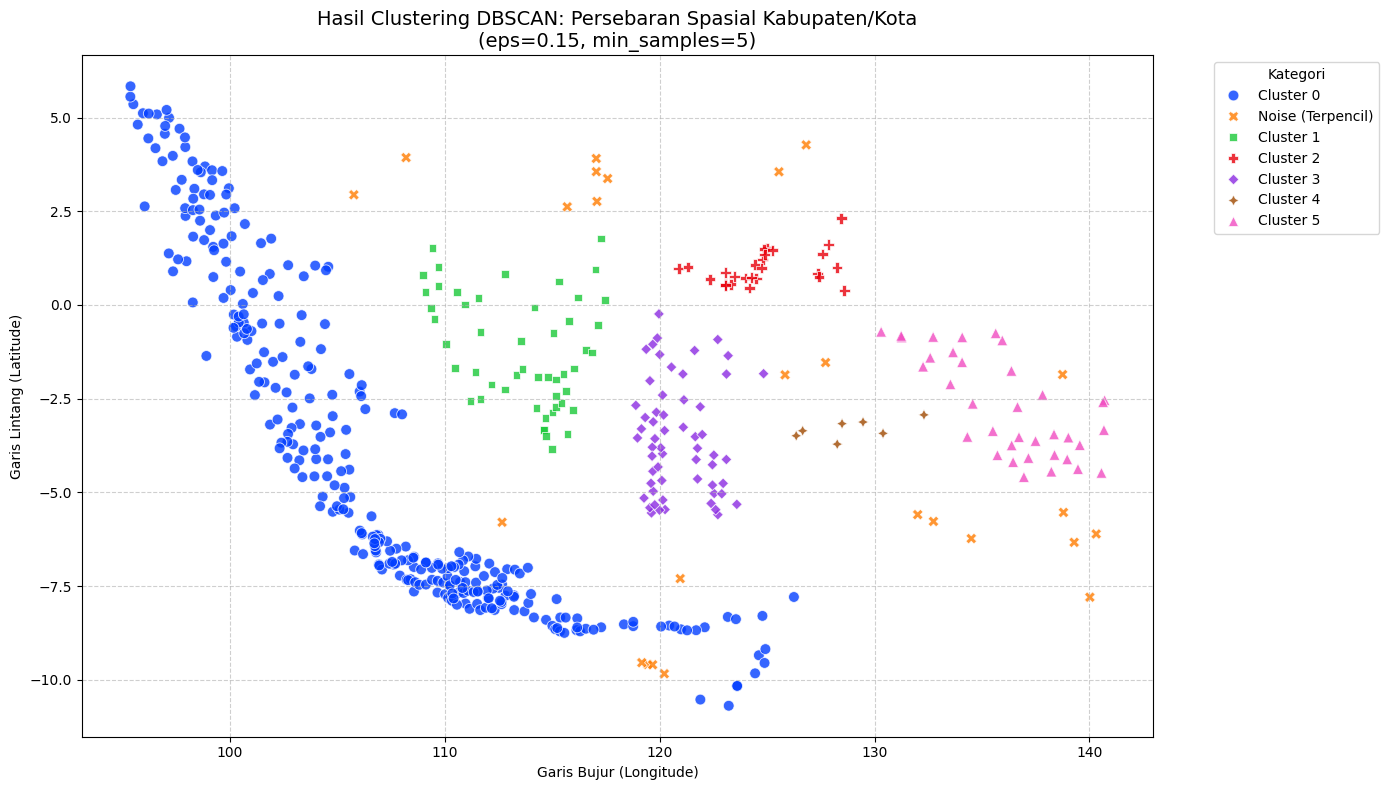

In [53]:
plt.figure(figsize=(14, 8))


sns.scatterplot(
    data=df_clean,
    x='longitude',
    y='latitude',
    hue='Label',
    palette='bright',
    style='Label',
    s=60,
    alpha=0.8
)

plt.title(f'Hasil Clustering DBSCAN: Persebaran Spasial Kabupaten/Kota\n(eps={epsilon}, min_samples={min_samples})', fontsize=14)
plt.xlabel('Garis Bujur (Longitude)')
plt.ylabel('Garis Lintang (Latitude)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Kategori')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()